In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func,inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# finding the columns and data types available in database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')

for column in columns:
    print(column['name'],column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# finding the columns and data types available in database
columns1 = inspector.get_columns('station')

for column1 in columns1:
    print(column1['name'],column1['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [12]:
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

# Exploratory Climate Analysis

![precipitation](Images/precipitation.png)

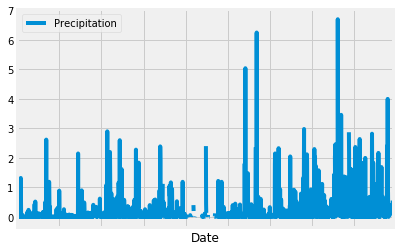

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
last_data_point = session.query(Measurement.date).order_by(Measurement.date.desc()).first()


daate = last_data_point[0]

dtt = datetime.strptime(last_data_point[0],'%Y-%m-%d')


Last_year_date = dt.date(dtt.year,dtt.month,dtt.day)-dt.timedelta(days =365)


# Perform a query to retrieve the data and precipitation scores

result= session.query(Measurement.date, Measurement.prcp).filter(Measurement.date>=Last_year_date).filter(Measurement.date<=daate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

df= pd.DataFrame(result, columns= ['Date','Precipitation'])

df.set_index('Date', inplace= True)

# Sort the dataframe by date

df.sort_values('Date').head()

# Use Pandas Plotting with Matplotlib to plot the data

# df.plot(kind = "bar",figsize=(200,100))
df.plot()
plt.tick_params(labelbottom=False)

plt.show()


In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [15]:
engine.execute('select * from station ').fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6),
 (6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5),
 (7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9),
 (8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9),
 (9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)]

In [16]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.name)).all()

[(9)]

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


session.query(Station.station,func.count(Measurement.station)).filter(Station.station ==Measurement.station).group_by(Station.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Station.station == Measurement.station).\
filter(Station.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

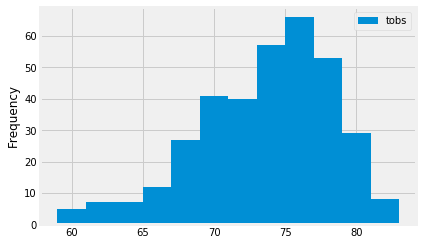

In [19]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps = session.query(Measurement.tobs).filter(Measurement.date>=Last_year_date).filter(Measurement.date<=daate).filter(Station.station == Measurement.station).\
filter(Station.station == 'USC00519281').all()
temp = [x[0] for x in temps]
df = pd.DataFrame(temp,columns = ["tobs"])
df.plot.hist(df['tobs'],bins = 12)
plt.ylabel("Frequency")
plt.show()

![precipitation](Images/station-histogram.png)

In [20]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
temp_range = calc_temps('2016-02-28', '2017-02-28')

lst_temp = list(temp_range[0])
print(lst_temp)

[59.0, 74.14365832614322, 84.0]


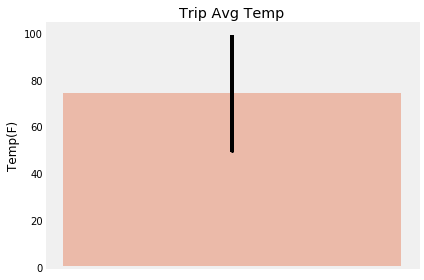

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
maxmm = lst_temp[2]
minmm = lst_temp[0]
avg_value = lst_temp[1]
err = maxmm-minmm

plt.grid()
plt.bar(1,avg_value, yerr=err, color='darksalmon',alpha=0.6, ecolor='black', capsize=1)
plt.tight_layout()
plt.title("Trip Avg Temp")
plt.ylabel("Temp(F)")
plt.xticks([])
plt.tight_layout()
plt.show()

In [23]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

session.query(Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation, func.sum(Measurement.prcp)).group_by(Station.station).order_by(func.sum(Measurement.prcp).desc()).filter(Station.station==Measurement.station).filter(Measurement.date>='2016-01-01').filter( Measurement.date<='2017-01-01').all()

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  162.91000000000003),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  79.92),
 ('USC00513117',
  'KANEOHE 838.1, HI US',
  21.4234,
  -157.8015,
  14.6,
  52.440000000000026),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  30.76999999999999),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  27.29),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 16.15),
 ('USC00517948',
  'PEARL CITY, HI US',
  21.3934,
  -157.9751,
  11.9,
  2.9700000000000006)]

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip

# trip_days = ['01-01','01-02','01-03','01-04','01-05','01-06','01-07']

# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date

start_date = dt.date(2017,1,1)
end_date = dt.date(2017,1,7)

trip_days = []

delta = end_date - start_date

for i in range(delta.days + 1):
    trip_days.append(datetime.strftime(start_date + dt.timedelta(days=i),'%m-%d'))

# trip_days_formatted = []
# for x in range(len(trip_days)):
#     trip_days_formatted.append[datetime.strptime(trip_days[x],'%m-%d')]
# trip_days_formatted

normals=[]
for x in trip_days:
    normals.append(daily_normals(x)[0])
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [26]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df_normals = pd.DataFrame(normals,columns = ['tmin','tavg','tmax'])
start_date1 = dt.date(2017,1,1)
end_date1 = dt.date(2017,1,7)

trip_days1 = []

delta1 = end_date1 - start_date1

for i in range(delta1.days + 1):
    trip_days1.append(datetime.strftime(start_date1 + dt.timedelta(days=i),'%Y-%m-%d'))


df_normals['Date'] = trip_days1
df_normals.set_index('Date',inplace=True)
df_normals

,tmin,tavg,tmax
Date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0
2017-01-06,61.0,68.964912,76.0
2017-01-07,57.0,68.543860,76.0


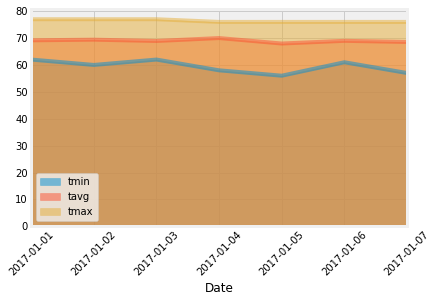

In [27]:
# Plot the daily normals as an area plot with `stacked=False`
df_normals.plot.area(stacked = False)
plt.xticks(rotation=45)
plt.show()